In [1]:
import sys
sys.path.insert(0, '../')

import torch
import numpy as np
import pylab as plt

from models import build_model
from datasets import build_dataset, build_ood_datasets
from metrics import calibration, ood, generalization
from tqdm.auto import tqdm

/home/denis/miniconda3/envs/uncertainty_evaluation/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Loading model
checkpoint = torch.load('../results/CIFAR10__wideresnet2810_mcdropout/seed1/checkpoint.pth')
model_dict = build_model(checkpoint['args'], n_classes=10, train_ds=None)
model = model_dict['model']
model.load_state_dict(checkpoint['model'])

# Load datasets
train_ds, test_ds, ds_info = build_dataset(checkpoint['args'])
ood_datasets = build_ood_datasets(checkpoint['args'], ds_info['mean'], ds_info['std'])

Files already downloaded and verified
Files already downloaded and verified
Using downloaded and verified file: ./data/test_32x32.mat


In [15]:
# forward prop
batch_size = 128
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=batch_size, sampler=None)
ood_loader = torch.utils.data.DataLoader(ood_datasets['SVHN'], batch_size=batch_size, sampler=None)
n_mc_samples = 10

device = 'cuda'
model.to(device)
model.eval()

logits, targets = [], []
for inp, tar in tqdm(test_loader):
    with torch.no_grad():
        logits.append(model.mc_forward(inp.to(device), k=n_mc_samples).cpu())
        targets.append(tar)
logits = torch.cat(logits)
targets = torch.cat(targets)

logits_ood = []
for inp, tar in tqdm(ood_loader):
    with torch.no_grad():
        logits_ood.append(model.mc_forward(inp.to(device), k=n_mc_samples).cpu())
logits_ood = torch.cat(logits_ood)

100%|██████████| 204/204 [03:07<00:00,  1.09it/s]


In [4]:
# Compute results
probas_id = logits.softmax(-1).mean(1)
probas_ood = logits_ood.softmax(-1).mean(1)
entropy_id = ood.entropy_fn(probas_id)
entropy_ood = ood.entropy_fn(probas_ood)
tce_criterion = calibration.TopLabelCalibrationError()
bs_criterion = calibration.BrierScore()
nll_criterion = torch.nn.NLLLoss()

result_dict = {
    'ACC': generalization.accuracy(probas_id, targets)[0].item(),
    'TCE': tce_criterion(probas_id, targets).item(),
    'NLL': nll_criterion(probas_id.log(), targets).item(),
    'BS': bs_criterion(probas_id, targets).item(),
    'AUROC': ood.ood_auroc(entropy_id, entropy_ood)
}
print(result_dict)

{'ACC': 96.32999420166016, 'TCE': 0.02081972546875477, 'NLL': 0.14580300450325012, 'BS': 0.005995458457618952, 'AUROC': 0.9460529156422863}


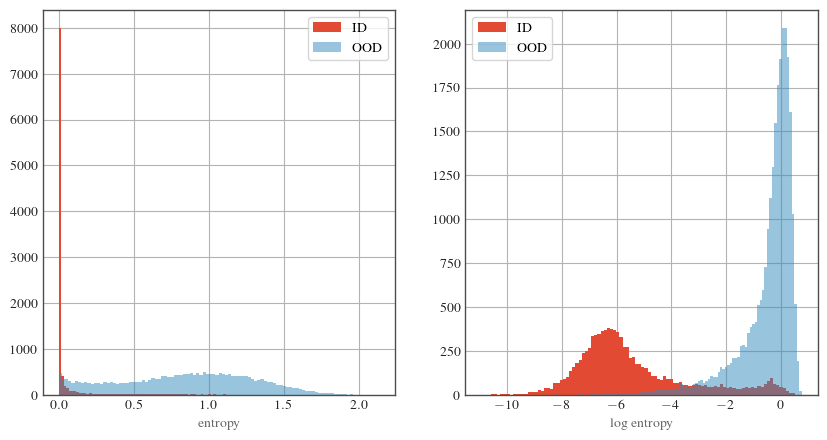

In [16]:
# Plot ood histogram
plt.subplot(121)
plt.hist(entropy_id, bins=100, label='ID')
plt.hist(entropy_ood, bins=100, alpha=.5, label='OOD')
plt.xlabel('entropy')

plt.legend()
plt.subplot(122)
plt.hist(entropy_id.log(), bins=100, label='ID')
plt.hist(entropy_ood.log(), bins=100, alpha=.5, label='OOD')
plt.xlabel('log entropy')
plt.legend()
plt.show()

<BarContainer object of 15 artists>

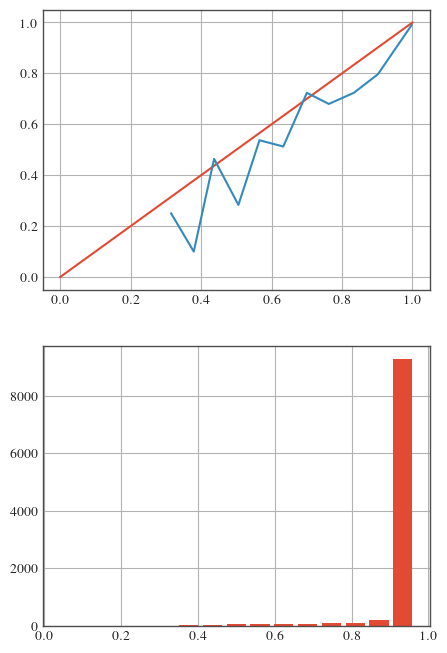

In [17]:
# Plot reliability diagram
tcp_dict = tce_criterion.results
plt.figure(figsize=(5, 8))
plt.subplot(211)
plt.plot([0, 1], [0, 1])
plt.plot(tcp_dict['confs'], tcp_dict['accs'])
plt.subplot(212)
plt.bar(np.linspace(1/15, 1-1/15, 15), tcp_dict['n_samples'], width=.05)

In [3]:
import time
# forward prop
results = []
params = [
    {'n_mcsamples': 1, 'batch_size': 128}, 
    {'n_mcsamples': 5, 'batch_size': 128}, 
    {'n_mcsamples': 10, 'batch_size': 64}, 
    {'n_mcsamples': 20, 'batch_size': 32}, 
    {'n_mcsamples': 50, 'batch_size': 16}, 
    {'n_mcsamples': 100, 'batch_size': 8}, 
]
for param in params:
    print(param)
    n_mcsamples = param['n_mcsamples']
    batch_size = param['batch_size']
    test_loader = torch.utils.data.DataLoader(test_ds, batch_size=batch_size, sampler=None)
    ood_loader = torch.utils.data.DataLoader(ood_datasets['SVHN'], batch_size=batch_size, sampler=None)
    device = 'cuda'
    model.to(device)
    model.eval()

    t1 = time.time()
    logits, targets = [], []
    for inp, tar in tqdm(test_loader):
        with torch.no_grad():
            logits.append(model.mc_forward(inp.to(device), k=n_mcsamples).cpu())
            targets.append(tar)
    logits = torch.cat(logits)
    targets = torch.cat(targets)

    logits_ood = []
    for inp, tar in tqdm(ood_loader):
        with torch.no_grad():
            logits_ood.append(model.mc_forward(inp.to(device), k=n_mcsamples).cpu())
    logits_ood = torch.cat(logits_ood)
    t2 = time.time()

    # Compute results
    probas_id = logits.softmax(-1).mean(1)
    probas_ood = logits_ood.softmax(-1).mean(1)
    entropy_id = ood.entropy_fn(probas_id)
    entropy_ood = ood.entropy_fn(probas_ood)
    tce_criterion = calibration.TopLabelCalibrationError()
    bs_criterion = calibration.BrierScore()
    nll_criterion = torch.nn.NLLLoss()

    result_dict = {
        'ACC': generalization.accuracy(probas_id, targets)[0].item(),
        'TCE': tce_criterion(probas_id, targets).item(),
        'NLL': nll_criterion(probas_id.log(), targets).item(),
        'BS': bs_criterion(probas_id, targets).item(),
        'AUROC': ood.ood_auroc(entropy_id, entropy_ood),
        'TIME': t2 - t1
    }
    results.append(result_dict)

{'n_mcsamples': 1, 'batch_size': 128}


100%|██████████| 204/204 [00:27<00:00,  7.45it/s]


{'n_mcsamples': 5, 'batch_size': 128}


100%|██████████| 204/204 [02:02<00:00,  1.67it/s]


{'n_mcsamples': 10, 'batch_size': 64}


100%|██████████| 407/407 [04:05<00:00,  1.66it/s]


{'n_mcsamples': 20, 'batch_size': 32}


100%|██████████| 814/814 [08:11<00:00,  1.66it/s]


{'n_mcsamples': 50, 'batch_size': 16}


100%|██████████| 1627/1627 [19:54<00:00,  1.36it/s]


{'n_mcsamples': 100, 'batch_size': 8}


100%|██████████| 3254/3254 [40:46<00:00,  1.33it/s]


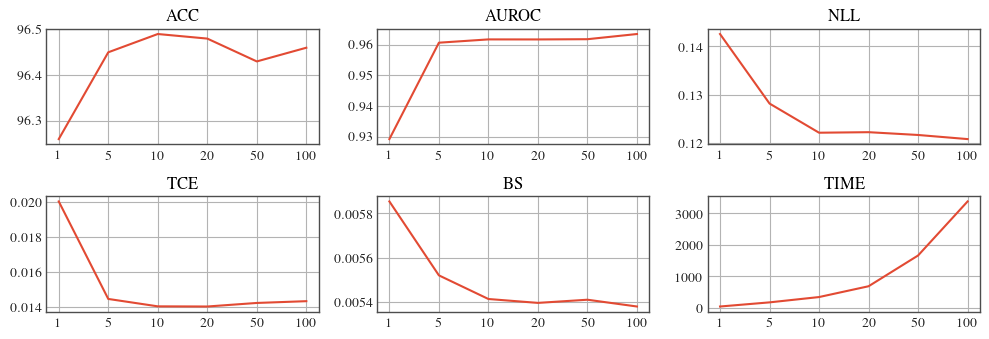

In [13]:
plt.subplot(331)
plt.title('ACC')
plt.plot([d['ACC'] for d in results])
plt.xticks(range(len(params)), [d['n_mcsamples'] for d in params])
plt.subplot(332)
plt.title('AUROC')
plt.plot([d['AUROC'] for d in results])
plt.xticks(range(len(params)), [d['n_mcsamples'] for d in params])
plt.subplot(333)
plt.title('NLL')
plt.plot([d['NLL'] for d in results])
plt.xticks(range(len(params)), [d['n_mcsamples'] for d in params])
plt.subplot(334)
plt.title('TCE')
plt.plot([d['TCE'] for d in results])
plt.xticks(range(len(params)), [d['n_mcsamples'] for d in params])
plt.subplot(335)
plt.title('BS')
plt.plot([d['BS'] for d in results])
plt.xticks(range(len(params)), [d['n_mcsamples'] for d in params])

plt.subplot(336)
plt.title('TIME')
plt.plot([d['TIME'] for d in results])
plt.xticks(range(len(params)), [d['n_mcsamples'] for d in params])
plt.tight_layout()
plt.show()